# Pre-whitening

### Downloading data

In [ ]:
from astropy.io import fits
import requests, io

URL = 'http://archive.stsci.edu/pub/kepler/lightcurves/0018/001869783/kplr001869783-2009350155506_llc.fits'
r = requests.get(URL)
fits.open(io.BytesIO(r.content))

### Pre-whitening

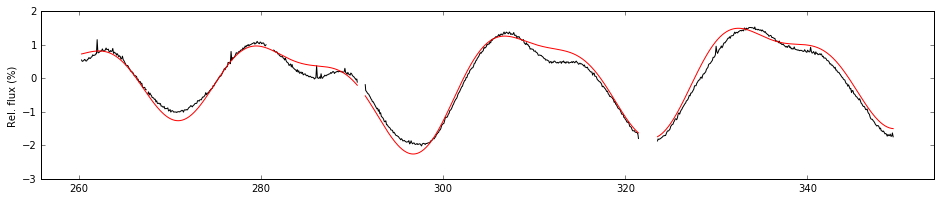

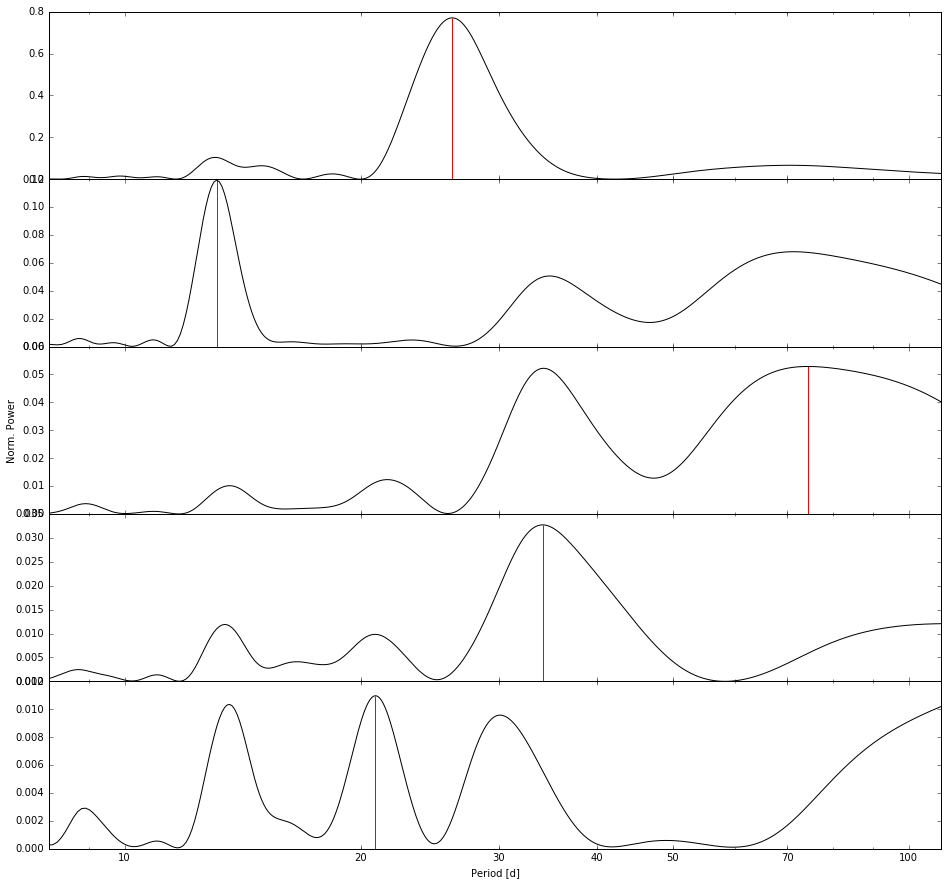

In [61]:
%matplotlib inline
import matplotlib, warnings
from astropy.io import fits
from scipy.signal import lombscargle

def getPhaseOffset(x, y, omega):
    """Get the phase offset of a fit to X, Y with frequency OMEGA."""
    return np.arctan2(np.nansum(y * np.sin(omega * x)),
                      np.nansum(y * np.cos(omega * x)))

def periodogram(time, flux, ang_freqs):
    # Create periodogram using scipy.signal.lombscargle
    pgram = lombscargle(time, flux, ang_freqs)
    # Normalize periodogram power
    power = pgram * 2 / (f.size * f.std()**2)
    return power

# Open .fits file for KIC 1869783, grab time and flux
hdulist = fits.open('001869783/kplr001869783-2009350155506_llc.fits')
data = hdulist[1].data
time = data['TIME'].byteswap().newbyteorder().astype('float64')
flux = data['PDCSAP_FLUX'].byteswap().newbyteorder().astype('float64')

# Normalize flux and remove offset
flux = (flux - np.nanmean(flux)) / np.nanmean(flux) * 100

# Bin the data at 2 hour bins => 4 data points in long cadence
binwidth = 4
with warnings.catch_warnings(): # Suppress 'mean of empty slice' warnings for all NaN bins
    warnings.simplefilter('ignore', category=RuntimeWarning)
    binned_time = np.nanmean(time[:time.size//binwidth * binwidth].reshape(-1, binwidth), axis=1)
    binned_flux = np.nanmean(flux[:flux.size//binwidth * binwidth].reshape(-1, binwidth), axis=1)

# Remove NaN data
t = binned_time[~np.isnan(binned_flux)]

# Period search space
periods = np.linspace(8.0, 110.0, 1000)
ang_freqs = 2*np.pi / periods

# Plotting and array initializations
ffig, ax = plt.subplots(figsize=(16, 3))
ax.plot(binned_time, binned_flux, 'k')

depth = 5 # Number of periodograms
fig, axarr = plt.subplots(depth, 1, sharex=True, figsize=(16, depth*3))
new_flux = binned_flux.copy()
total_fit = np.zeros_like(binned_flux)

# Loop to create 5 periodograms
for i in range(depth):
    # Remove NaN data from flux before supplying to function
    power = periodogram(t, new_flux[~np.isnan(binned_flux)], ang_freqs)

    # Get fit parameters using maximum power and its period
    j = power.argmax()
    period = periods[j]
    amplitude = np.sqrt(2 * power.max())
    phi = getPhaseOffset(t, f, ang_freqs[j])
    fit = amplitude * np.cos(binned_time * 2*np.pi/period - phi)

    # Subtract fit from flux for next periodogram
    new_flux -= fit
    # Add fit to total fit
    total_fit += fit

    # Plot periodogram
    axarr[i].plot(periods, power, 'k')
    axarr[i].vlines(period, 0, power.max(), colors='r')

# Plot total fit over original binned lightcurve
ax.plot(binned_time, total_fit, 'r')
ax.margins(x=0.05)
ax.set_xticks(range(260, 360, 20))
ax.set_ylabel('Rel. flux (%)')
ax.set_ylim(-3, 2)
ax.set_yticks(range(-3, 3))

# Label the periodogram plots
axarr[0].set_yticks(np.arange(0, 1, 0.2))
axarr[depth//2].set_ylabel('Norm. Power')
axarr[-1].set_xlabel('Period [d]')
axarr[-1].set_xscale('log')
axarr[-1].set_xlim(periods[0], periods[-1])
axarr[-1].set_xticks([10, 20, 30, 40, 50, 70, 100])
axarr[-1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
fig.subplots_adjust(hspace=0)